Importamos las librerias. Algunas son para el uso de la GPU, otras son para el proyecto

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import subprocess
import cv2
from tensorflow.keras.callbacks import EarlyStopping



2024-05-11 13:06:23.300168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 13:06:24.718462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
# Verificar si TensorFlow detecta GPU
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU detectada:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No se detectó GPU. Se utilizará la CPU.')

GPU detectada:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-05-11 13:06:49.264860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 13:06:49.715314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 13:06:49.715570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Para que el programa utilice la VRAM que tiene el sistema y no la RAM de la computadora

In [3]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


Leer la base de datos creada con anterioridad y ver su contenido

In [4]:
df = pd.read_hdf('BD_Biomasa.h5')

In [5]:
df.head()

,Imagen,Biomasa g/L,Etiqueta
0,"[[[45, 107, 1], [43, 106, 0], [43, 106, 0], [5...",1.000,roi_329
1,"[[[16, 113, 0], [14, 113, 0], [14, 112, 0], [1...",1.667,roi_539
2,"[[[0, 82, 0], [0, 81, 0], [0, 82, 0], [0, 83, ...",2.539,roi_859
3,"[[[55, 105, 15], [56, 106, 16], [56, 107, 17],...",0.667,roi_220
4,"[[[100, 108, 57], [102, 110, 59], [100, 108, 5...",0.333,roi_063


Verificar que no sea irregular de imagen y rostro

In [6]:
print(df['Imagen'].shape)

(1080,)


Separamos las caracteristicas y etiquetas

In [7]:
# Separar las características y etiquetas
X = np.array(df['Imagen'])
y = df['Biomasa g/L']

Verificamos el formato, que sea ideal para la CNN

In [8]:
print(df['Imagen'].values[0].shape)

(150, 150, 3)


Dado que el formato de rostro puede ser menor o mayor medida, hay que adaptar todos los datos a un formato. En este caso lo escalamos a 150x150

In [9]:
print(X.shape)
print(X[0].shape)


(1080,)
(150, 150, 3)


In [10]:
for i in range(X.shape[0]):
    X[i] = np.array(Image.fromarray(X[i]).resize((150,150)))

Verificamos el formato 

In [11]:
print(X[0].shape)

(150, 150, 3)


Hacemos los datos de entrenamiento y los de prueba

In [12]:

# Dividir el dataset en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Normalizamos los datos de entrenamiento y los de valores para verificar en numpy array

In [13]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

In [14]:
print(X_train.shape)
print(X_train[0].shape)

(864, 150, 150, 3)
(150, 150, 3)


Todos los datos de entrenamiento los ponemos en tipo flotante 32 y lo dividimos en 255 (que es formato de imagen), esto para normalizar del 0 al 1

In [15]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [16]:
print(X_train.shape)
print(X_train[0].shape)

(864, 150, 150, 3)
(150, 150, 3)


Aqui lo aumentamos.

In [17]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
#train_generator = datagen.flow(X_train, y_train, batch_size=50)


Todo el modelo definido

In [18]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Capa de salida con activación softmax
])


/home/waldos/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-11 13:07:06.769588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 13:07:06.770037: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

Compilamos el modelo.

In [19]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


Entrenamos el modelo

In [20]:
# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [21]:
# Entrenar el modelo con el callback de TensorBoard
with tf.device('/device:GPU:0'):
    history = model.fit(X_train,y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping]
                    )


Epoch 1/50


I0000 00:00:1715458031.166963   10568 service.cc:145] XLA service 0x7f3a44004590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715458031.166991   10568 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2024-05-11 13:07:11.247804: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-11 13:07:11.576569: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1866 - mae: 1.2218

I0000 00:00:1715458035.067825   10568 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 1.4319 - mae: 0.9194 - val_loss: 0.1168 - val_mae: 0.2620
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1100 - mae: 0.2447 - val_loss: 0.0443 - val_mae: 0.1570
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0459 - mae: 0.1607 - val_loss: 0.0338 - val_mae: 0.1329
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0365 - mae: 0.1419 - val_loss: 0.0603 - val_mae: 0.1842
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0438 - mae: 0.1569 - val_loss: 0.0298 - val_mae: 0.1280
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0350 - mae: 0.1376 - val_loss: 0.0296 - val_mae: 0.1331
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0307 - mae: 0.1324 - val_loss: 0.0327 - val_mae: 0.1309
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0316 - mae: 0.1297 - val_loss: 0.0287 - val_mae: 0.1282
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0534 - mae: 0.

In [22]:
loss, mae = model.evaluate(X_val, y_val)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0295 - mae: 0.1299 


In [24]:
print("Mean Squared Error:", mae)
print("Loss:", loss)

Mean Squared Error: 0.12821848690509796
Loss: 0.028727205470204353


Guardamos el modelo

In [25]:
# Guardar el modelo
model.save('CNN_Biomasa_RGB.h5')

Obtenemos predicciones del conjunto de validacion

In [26]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Tabla graficamente de la precision y perdida del modelo a partir de las epocas

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


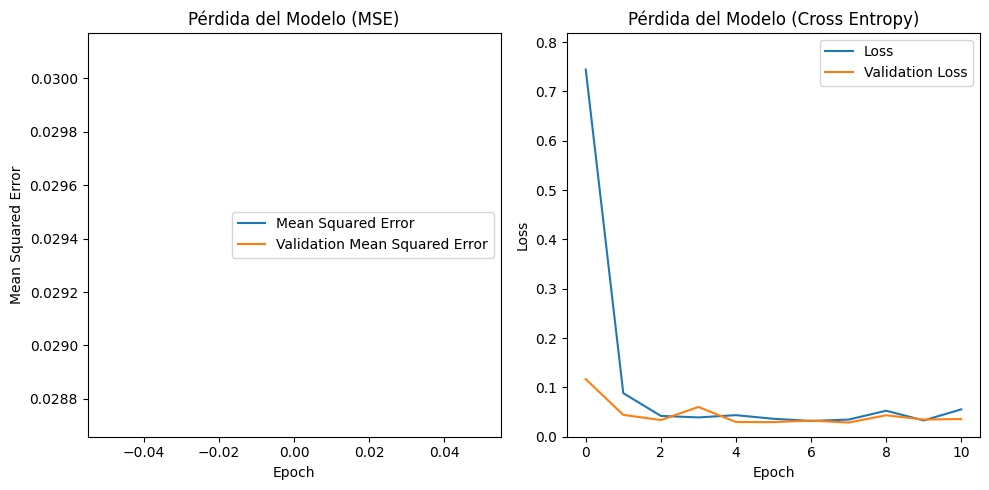

In [33]:
import matplotlib.pyplot as plt

# Calcular manualmente el MSE durante el entrenamiento
predicted_train = model.predict(X_train).flatten()
mse = np.mean((predicted_train - y_train)**2)

predicted_val = model.predict(X_val).flatten()
val_mse = np.mean((predicted_val - y_val)**2)

# Mostrar la pérdida y la precisión del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mse, label='Mean Squared Error')
plt.plot(val_mse, label='Validation Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Pérdida del Modelo (MSE)')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo (Cross Entropy)')

plt.tight_layout()
plt.show()

